In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from collections import defaultdict
import matplotlib.pyplot as plt

import sqlite3
import sys
import time
import tqdm

## Loading SQLite Database into Pandas DataFrames

The following code connects to an SQLite database (`melee_player_database.db`) and converts each table within the database into a pandas DataFrame. The DataFrames will be stored in a dictionary, where each key corresponds to the table name with `_df` appended, and the values are the respective DataFrames.

### Steps:

1. **Database Connection**: We use the `sqlite3` library to connect to the SQLite database file.
2. **Retrieve Table Names**: A query retrieves all the table names in the database.
3. **Convert Tables to DataFrames**: For each table:
   - The table is loaded into a pandas DataFrame using `pd.read_sql()`.
   - We check each column to see if any data is JSON-formatted (lists or dictionaries). If so, we convert these columns from strings into their corresponding Python objects using `json.loads()`.
4. **Store DataFrames**: The DataFrames are stored in a dictionary, where the key is the table name with a `_df` suffix, and the value is the DataFrame.
5. **Database Connection Closed**: Once all tables are loaded into DataFrames, the database connection is closed.

### Example:
If the database contains a table named `players`, the corresponding DataFrame will be stored in the dictionary with the key `players_df`, and can be accessed as:

```python
players_df = dfs['players_df']


In [5]:
# Function to get the table names
def get_table_names(conn):
    query = "SELECT name FROM sqlite_master WHERE type='table';"
    return pd.read_sql(query, conn)['name'].tolist()

# Function to load tables into DataFrames
def load_tables_to_dfs(conn):
    table_names = get_table_names(conn)
    dataframes = {}
    
    for table in table_names:
        # Load table into a DataFrame
        df = pd.read_sql(f"SELECT * FROM {table}", conn)
        
        # Detect and convert JSON formatted columns (if any)
        for col in df.columns:
            # Check if any entry in the column is a valid JSON (list or dictionary)
            if df[col].apply(lambda x: isinstance(x, str)).all():
                try:
                    # Try parsing the column as JSON
                    df[col] = df[col].apply(lambda x: json.loads(x) if pd.notnull(x) else x)
                except (json.JSONDecodeError, TypeError):
                    # If it fails, skip the column
                    pass
        
        # Store the DataFrame with table name + '_df'
        dataframes[f"{table}_df"] = df
        
    return dataframes

# Check if the flag variable exists in the global scope so that this code does not run twice
if 'cell_has_run' not in globals():
    path = "../data/melee_player_database.db"
    
    # Connect to the database
    conn = sqlite3.connect(path)

    # Convert each table into a DataFrame
    dfs = load_tables_to_dfs(conn)

    # Close the connection
    conn.close()

    # Now, you have a dictionary 'dfs' where each key is the table name with '_df' suffix and value is the corresponding DataFrame.
    # For example, to access the DataFrame for a table called 'players':
    # players_df = dfs['players_df']

    dfs['tournament_info_df']['start'] = pd.to_datetime(dfs['tournament_info_df']['start'], unit='s')
    dfs['tournament_info_df']['end'] = pd.to_datetime(dfs['tournament_info_df']['end'], unit='s')

    
    # Set the flag to indicate that the cell has been run
    cell_has_run = True

### Here we adjust the data types of the dataframes so that they are the correct type. (This will be updated as needed.)

In [6]:
dfs['sets_df']['best_of'] = dfs['sets_df']['best_of'].fillna(0).astype(int) 

### Here we make dataframes that we will use and print the head.

The integers in 'characters' count the number of games the player has played that character. (We verify this for Zain below.)

In [7]:
players_df = dfs['players_df']
players_df.head()

,game,player_id,tag,all_tags,prefixes,social,country,state,region,c_country,c_state,c_region,placings,characters,alias
0,melee,Rishi,Rishi,[Rishi],[],{'twitter': []},,,,None,None,None,[{'key': 'mdva-invitational-2017-(challonge-mi...,,None
1,melee,15634,lloD,"[lloD, VGz | lloD, Llod]",[],{'twitter': ['lloD74']},United States,VA,,US,CA,Laurel,[{'key': 'mdva-invitational-2017-(challonge-mi...,"{'melee/peach': 1089, 'melee/falco': 1, 'melee...",None
2,melee,6126,Zain,"[Zain, DontTestMe]",[PG],{'twitter': ['PG_Zain']},United States,VA,,US,CA,Los Angeles,[{'key': 'mdva-invitational-2017-(challonge-mi...,"{'melee/marth': 1065, 'melee/pichu': 1, 'melee...",DontTestMe
3,melee,Chu,Chu,[Chu],[],{'twitter': []},,,,None,None,None,[{'key': 'mdva-invitational-2017-(challonge-mi...,,None
4,melee,5620,Junebug,"[Junebug, LS | VGz Junebug]",[],{'twitter': ['arJunebug']},United States,VA,,US,VA,Richmond,[{'key': 'mdva-invitational-2017-(challonge-mi...,"{'melee/sheik': 46, 'melee/falco': 4, 'melee/g...",None


In [8]:
ranking_df = dfs['ranking_df']
ranking_df.head()

,game,ranking_name,priority,region,seasons,tournaments,icon
0,melee,SSBMRank,0,world,"[2015, 2016, 2017, 2018, 2019]",[],miom


In [9]:
ranking_seasons_df = dfs['ranking_seasons_df']
ranking_seasons_df.head()

,game,ranking_name,season,start,end,total,by_id,by_placing,final,name
0,melee,SSBMRank,2015,1420070400,1451606399,100,"{'6189': 1, '1004': 2, '4465': 3, '1000': 4, '...","{'1': '6189', '2': '1004', '3': '4465', '4': '...",0,None
1,melee,SSBMRank,2016,1451606400,1483228799,100,"{'6189': 1, '1004': 2, '1000': 3, '1003': 4, '...","{'1': '6189', '2': '1004', '3': '1000', '4': '...",0,None
2,melee,SSBMRank,2017,1483228800,1514764799,100,"{'1004': 1, '6189': 2, '1000': 3, '1003': 4, '...","{'1': '1004', '2': '6189', '3': '1000', '4': '...",0,None
3,melee,SSBMRank,2018,1514793600,1546329600,100,"{'1004': 1, '6189': 2, '4465': 3, '15990': 4, ...","{'1': '1004', '2': '6189', '3': '4465', '4': '...",0,None
4,melee,SSBMRank,2019,1546329600,1577836800,100,"{'1004': 1, '4465': 2, '1000': 3, '16342': 4, ...","{'1': '1004', '2': '4465', '3': '1000', '4': '...",0,None


In [10]:
sets_df = dfs['sets_df']
print(f'{sets_df[sets_df['game_data'].apply(lambda x: len(x) > 0)].shape[0] / sets_df.shape[0]:0.01%} percent of sets have some game data')
sets_df.head()

32.9% percent of sets have some game data


,key,game,tournament_key,winner_id,p1_id,p2_id,p1_score,p2_score,location_names,bracket_name,bracket_order,set_order,best_of,game_data
0,104675843,melee,mdva-invitational-2017-(challonge-mirror),5620,5620,Chillin,3,1,"[R1, Round 1, Round 1]",,1,A,5,[]
1,104675844,melee,mdva-invitational-2017-(challonge-mirror),Aglet,15634,Aglet,2,3,"[R1, Round 1, Round 1]",,1,B,5,[]
2,104675845,melee,mdva-invitational-2017-(challonge-mirror),6126,6126,1097,3,0,"[R1, Round 1, Round 1]",,1,C,5,[]
3,104675846,melee,mdva-invitational-2017-(challonge-mirror),1069,Chu,1069,0,3,"[R1, Round 1, Round 1]",,1,D,5,[]
4,104675847,melee,mdva-invitational-2017-(challonge-mirror),Rishi,Jerry,Rishi,1,3,"[R1, Round 1, Round 1]",,1,E,5,[]


In [11]:
tournament_info_df = dfs['tournament_info_df']
tournament_info_df.head()


,game,key,cleaned_name,source,tournament_name,tournament_event,season,rank,start,end,country,state,city,entrants,placings,losses,bracket_types,online,lat,lng
0,melee,mdva-invitational-2017-(challonge-mirror),MDVA Invitational 2017 (Challonge Mirror),challonge,https://challonge.com/mdva_invitational_2017,,17,,2017-11-26 08:05:11,2017-11-26 08:48:09,US,VA,Fall's Church,10,"[[Rishi, 1], [15634, 3], [6126, 4], [Chu, 8], ...",{},b'{}',0,NaN,NaN
1,melee,s@sh7,S@SH7,challonge,https://challonge.com/sash7,,17,,2017-06-13 10:27:01,2017-06-13 10:27:01,US,MI,Ann Arbor,92,[],{},b'{}',0,NaN,NaN
2,melee,slippi-champions-league-week-1__melee-singles,Slippi Champions League Week 1,pgstats,slippi-champions-league-week-1,melee-singles,20,,2020-10-11 14:00:00,2020-10-11 14:00:00,,,,20,"[[1000, 1], [6126, 2], [4107, 3], [19554, 3], ...",{},b'{}',1,0.0,0.0
3,melee,slippi-champions-league-week-2__melee-singles,Slippi Champions League Week 2,pgstats,slippi-champions-league-week-2,melee-singles,20,,2020-10-18 14:00:00,2020-10-18 14:00:00,,,,20,"[[6126, 1], [4107, 2], [1000, 3], [19554, 3], ...",{},b'{}',1,0.0,0.0
4,melee,slippi-champions-league-week-3__melee-singles,Slippi Champions League Week 3,pgstats,slippi-champions-league-week-3,melee-singles,20,,2020-10-25 14:00:00,2020-10-25 14:00:00,,,,20,"[[6126, 1], [3359, 2], [19554, 3], [4107, 3], ...",{},b'{}',1,0.0,0.0


In [12]:
n = 1206
print(tournament_info_df.loc[n]['entrants'])
print(len(tournament_info_df.loc[n]['placings']))
print(tournament_info_df.loc[n]['placings'])


30
30
[['15263', 2], ['15685', 4], ['876697', 17], ['288009', 3], ['30676', 5], ['11846', 17], ['3665', 13], ['1918686', 25], ['557039', 25], ['173775', 17], ['136379', 9], ['3598', 17], ['19912', 25], ['22398', 17], ['618857', 17], ['409084', 9], ['2207069', 25], ['170866', 25], ['671783', 13], ['50317', 13], ['3792', 25], ['2159846', 5], ['394148', 9], ['36619', 17], ['237282', 9], ['219761', 13], ['184090', 7], ['15379', 7], ['1717035', 17], ['1061', 1]]


## Investigate data for Zain
We choose zain because he is in the best player in the head of the players_df.

In [13]:
zain_df = players_df.iloc[2]
print('Zain has played in', len(zain_df['placings']), 'tournaments.')

# Dataframe of tournaments that zain has played in.
zain_tournament_keys = [tournament['key'] for tournament in zain_df['placings']]
zain_tournament_info_df = tournament_info_df[tournament_info_df['key'].isin(zain_tournament_keys)]

Zain has played in 180 tournaments.


In [14]:
print(zain_tournament_info_df.info())
zain_tournament_info_df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 180 entries, 0 to 39443
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   game              180 non-null    object        
 1   key               180 non-null    object        
 2   cleaned_name      180 non-null    object        
 3   source            180 non-null    object        
 4   tournament_name   180 non-null    object        
 5   tournament_event  180 non-null    object        
 6   season            180 non-null    object        
 7   rank              180 non-null    object        
 8   start             180 non-null    datetime64[ns]
 9   end               180 non-null    datetime64[ns]
 10  country           126 non-null    object        
 11  state             124 non-null    object        
 12  city              114 non-null    object        
 13  entrants          180 non-null    int64         
 14  placings          180 non-nul

,game,key,cleaned_name,source,tournament_name,tournament_event,season,rank,start,end,country,state,city,entrants,placings,losses,bracket_types,online,lat,lng
0,melee,mdva-invitational-2017-(challonge-mirror),MDVA Invitational 2017 (Challonge Mirror),challonge,https://challonge.com/mdva_invitational_2017,,17,,2017-11-26 08:05:11,2017-11-26 08:48:09,US,VA,Fall's Church,10,"[[Rishi, 1], [15634, 3], [6126, 4], [Chu, 8], ...",{},b'{}',0,NaN,NaN
2,melee,slippi-champions-league-week-1__melee-singles,Slippi Champions League Week 1,pgstats,slippi-champions-league-week-1,melee-singles,20,,2020-10-11 14:00:00,2020-10-11 14:00:00,,,,20,"[[1000, 1], [6126, 2], [4107, 3], [19554, 3], ...",{},b'{}',1,0.0,0.0
3,melee,slippi-champions-league-week-2__melee-singles,Slippi Champions League Week 2,pgstats,slippi-champions-league-week-2,melee-singles,20,,2020-10-18 14:00:00,2020-10-18 14:00:00,,,,20,"[[6126, 1], [4107, 2], [1000, 3], [19554, 3], ...",{},b'{}',1,0.0,0.0
4,melee,slippi-champions-league-week-3__melee-singles,Slippi Champions League Week 3,pgstats,slippi-champions-league-week-3,melee-singles,20,,2020-10-25 14:00:00,2020-10-25 14:00:00,,,,20,"[[6126, 1], [3359, 2], [19554, 3], [4107, 3], ...",{},b'{}',1,0.0,0.0
5,melee,slippi-champions-league-week-4__melee-singles,Slippi Champions League Week 4,pgstats,slippi-champions-league-week-4,melee-singles,20,,2020-10-31 14:00:00,2020-10-31 14:00:00,,,,20,"[[6126, 1], [3357, 2], [15990, 3], [3359, 3], ...",{},b'{}',1,0.0,0.0


Here we make a dataframe containing all the sets that zain has played in and add some columns so that we can identify him more easily.

In [15]:
# Filter sets_df with Zain as a player and make a copy
zain_sets_df = sets_df[(sets_df['p1_id'] == zain_df['player_id']) | (sets_df['p2_id'] == zain_df['player_id'])].copy()
print('Zain has played', zain_sets_df.shape[0], 'sets.')

# Assuming zain_df['player_id'] gives Zain's player ID
zain_id = zain_df['player_id']

# Add a 'zain_win' column using .loc
zain_sets_df.loc[:, 'zain_win'] = ((zain_sets_df['p1_id'] == zain_id) & (zain_sets_df['p1_score'] > zain_sets_df['p2_score'])) | \
                                  ((zain_sets_df['p2_id'] == zain_id) & (zain_sets_df['p2_score'] > zain_sets_df['p1_score']))

# Add an 'opponent' column using .loc
zain_sets_df.loc[:, 'opponent'] = zain_sets_df.apply(
    lambda row: row['p1_id'] if row['p2_id'] == zain_id else row['p2_id'],
    axis=1
)

# Add 'zain_score' and 'opponent_score' columns using .loc
zain_sets_df.loc[:, 'zain_score'] = zain_sets_df.apply(
    lambda row: row['p1_score'] if row['p1_id'] == zain_id else row['p2_score'],
    axis=1
)

zain_sets_df.loc[:, 'opponent_score'] = zain_sets_df.apply(
    lambda row: row['p2_score'] if row['p1_id'] == zain_id else row['p1_score'],
    axis=1
)

# Filter the zain_sets_df for rows where 'game_data' is not an empty list
game_data_zain_sets_df = zain_sets_df[zain_sets_df['game_data'].apply(lambda x: len(x) > 0)]

# Display the result
print('Zain has played', game_data_zain_sets_df.shape[0], 'sets with game_data.')


Zain has played 1344 sets.
Zain has played 575 sets with game_data.


Here we check to see that zain_df['characters'] counts the number of games that zain has played that character.

In [16]:
# Ensure zain_id is a string to match the data in game_data
zain_id = str(zain_id)

# Initialize a dictionary to count Zain's characters
zain_characters_count = defaultdict(int)

# Loop through the 'game_data' for each set Zain played
for game_data in game_data_zain_sets_df['game_data']:
    for game in game_data:
        # Check if Zain was the winner or loser and increment the count of the character he used
        if str(game['winner_id']) == zain_id:  # Compare as strings
            zain_characters_count[game['winner_char']] += 1
        elif str(game['loser_id']) == zain_id:  # Compare as strings
            zain_characters_count[game['loser_char']] += 1

# Convert the defaultdict to a regular dict and display the result
zain_characters_count = dict(zain_characters_count)
# print(zain_characters_count)
# print(zain_df['characters'])

# Extract the characters dictionary from zain_df
zain_characters_actual = zain_df['characters']

# Find the keys that are common to both dictionaries
common_keys = set(zain_characters_count.keys()).intersection(set(zain_characters_actual.keys()))

# Compare the values for the keys that are common
for key in common_keys:
    if zain_characters_count[key] == zain_characters_actual[key]:
        print(f"{key}: Match - {zain_characters_count[key]} games")
    else:
        print(f"{key}: Mismatch - counted {zain_characters_count[key]} games, actual {zain_characters_actual[key]} games")

melee/luigi: Match - 2 games
melee/peach: Match - 1 games
melee/samus: Match - 1 games
melee/drmario: Match - 1 games
melee/zelda: Match - 1 games
melee/iceclimbers: Match - 2 games
melee/mewtwo: Match - 1 games
melee/jigglypuff: Match - 12 games
melee/captainfalcon: Match - 3 games
melee/roy: Match - 696 games
melee/sheik: Match - 37 games
melee/random: Match - 2 games
melee/fox: Match - 125 games
melee/pichu: Match - 1 games
melee/falco: Match - 10 games
melee/link: Match - 1 games
melee/marth: Match - 1065 games


## Overall Glicko-2 ##
We obtain a baseline of the predictive power of the Glicko-2 ratings we computed.

In [17]:
glicko2_df = pd.read_pickle('../data/overall_players_ranking.pkl')
glicko2_df.head(2)

,dates,rating_history,rd_history,glicko2
player_id,,,,
1000,"[2015-01-13 01:02:28, 2015-02-06 18:58:36, 201...","[1669.3438572516538, 1699.3674585229132, 1882....","[171.20863576993426, 129.71212804199854, 83.73...",<glicko2.glicko2.Player object at 0x739f91f6f020>
Stelzig,"[2015-01-13 01:02:28, 2015-08-17 23:13:14]","[1252.6819167554638, 1165.5738869144382]","[253.40460822505193, 211.92970378109877]",<glicko2.glicko2.Player object at 0x739f91f6ce60>


In [18]:
def check_set(glicko2_df, set, tournament_info_df, correct_predictions):
    tournament = set['tournament_key']
    p1_id = set['p1_id']
    p2_id = set['p2_id']
    start_date = tournament_info_df[tournament_info_df['key']==tournament]['start']
    
    p1_index = np.searchsorted(glicko2_df.loc[p1_id,'dates'], start_date) - 1
    p2_index = np.searchsorted(glicko2_df.loc[p2_id,'dates'], start_date) - 1
    
    p1_glikco2 = glicko2_df.loc[p1_id,'rating_history'][p1_index]
    p2_glikco2 = glicko2_df.loc[p2_id,'rating_history'][p2_index]
    
    if p1_glikco2 > p2_glikco2 and set['winner_id'] == p1_id:
        return  1
    
    
    return 0
        
num_sets = 60000
random_set_sample = sets_df.sample(n = num_sets, random_state=42)   
correct_predictions = 0

for j in tqdm.tqdm(range(num_sets)):
    correct_predictions += check_set(glicko2_df, random_set_sample.iloc[j], tournament_info_df, correct_predictions)

print(f'The higher Glicko-2 rating wins {correct_predictions/num_sets:0.1%} of the time')
    
# check_set(glicko2_df, sets_df.iloc[1000,:], tournament_info_df, correct_predictions)



100%|██████████| 60000/60000 [01:23<00:00, 722.84it/s]

The higher Glicko-2 rating wins 59.8% of the time


Characters sorted by total number of games played:
melee/fox: 666791
melee/falco: 527738
melee/marth: 378741
melee/sheik: 324823
melee/captainfalcon: 270238
melee/jigglypuff: 196904
melee/peach: 178763
melee/luigi: 92845
melee/samus: 88570
melee/ganondorf: 63117
melee/iceclimbers: 55233
melee/drmario: 48014
melee/yoshi: 37734
melee/pikachu: 37665
melee/link: 23251
melee/mrgameandwatch: 23080
melee/donkeykong: 20993
melee/mario: 20777
melee/zelda: 18738
melee/roy: 18665
melee/younglink: 15212
melee/kirby: 14992
melee/ness: 14782
melee/bowser: 10948
melee/pichu: 9515
melee/random: 9309
melee/mewtwo: 8544


Text(0.5, 1.0, 'Games Played By Character')

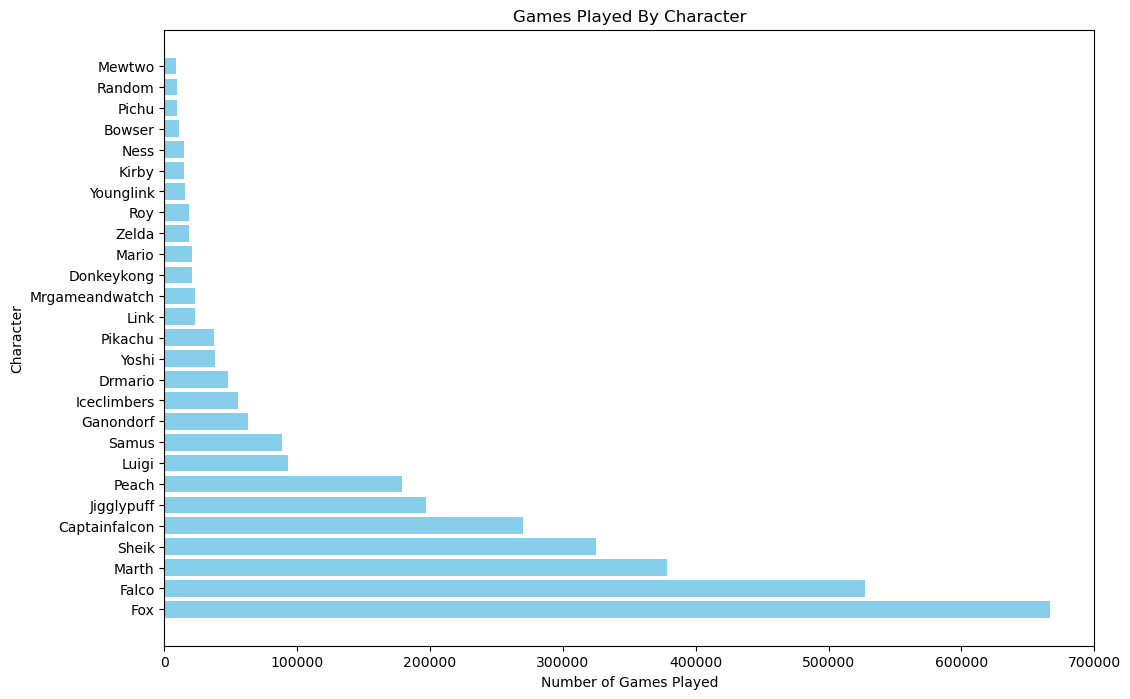

In [19]:


# Assume players_df is already loaded and contains the 'characters' column
# For this example, I'll use the provided players_df DataFrame

# Initialize an empty dictionary to store the total counts per character
total_character_counts = {}

# Iterate over the 'characters' column
for idx, row in players_df.iterrows():
    char_dict = row['characters']
    if isinstance(char_dict, dict):
        for character, count in char_dict.items():
            if character in total_character_counts:
                total_character_counts[character] += count
            else:
                total_character_counts[character] = count
    else:
        # Handle cases where 'characters' is empty or NaN
        continue

# Now total_character_counts contains the total counts per character

# Sort the characters by total counts in decreasing order
sorted_characters = sorted(total_character_counts.items(), key=lambda x: x[1], reverse=True)

# Print the list of characters sorted by total number of games played
print("Characters sorted by total number of games played:")
for character, count in sorted_characters:
    print(f"{character}: {count}")

# Prepare data for plotting
characters = [item[0] for item in sorted_characters]
counts = [item[1] for item in sorted_characters]
character_names = [character.split('/')[1].title() for character in characters]

# Plot the horizontal bar chart
plt.figure(figsize=(12, 8))
plt.barh(character_names, counts, color='skyblue')
plt.xlabel('Number of Games Played')
plt.ylabel('Character')
plt.title('Games Played By Character')

In [26]:
loaded = pd.read_pickle('../data/player_ratings_matchup_df.pkl')

In [27]:
loaded.columns

Index(['player_id', 'dates_dict', 'rating_history_dict', 'rd_history_dict',
       'game_count_dict', 'glicko2_dict'],
      dtype='object')

In [28]:
drop_col = loaded[['player_id', 'dates_dict', 'rating_history_dict', 'rd_history_dict',
       'game_count_dict']]

In [29]:
drop_col.to_pickle('../data/player_ratings_matchup_df_no_glicko.pkl')